# day 12 of #66daysofdata_NLP
## TF-IDF


* ref: 
- [https://www.youtube.com](https://www.youtube.com/watch?v=i74DVqMsRWY&list=PL2VXyKi-KpYttggRATQVmgFcQst3z6OlX&index=6)
* data set:
- [ TRC data](https://github.com/wjbmattingly/topic_modeling_textbook/tree/main/data) 
- Context:
    - a collection of descriptions of violence from apartheid South Africa from the 20th century.
    - JSON file of the TRC Volume 7 report. The JSON file is structured as a dictionary with two keys the first key is `names` and that corresponds to a list of the victim names.
    -  `Descriptions` of violence are not structured in any way. Instead they have rich metadata within them. This metadata consists of things like dates, places, and other organizations during the 20th century.


### TF-IDF
![App Screenshot](../images/TF-IDF.png)
- [img ref](https://www.youtube.com/watch?v=vZAXpvHhQow)

By evaluating TF-IDF or a number of “the words used in a sentence vs words used in overall document”, we understand -

- `how useful a word is to a sentence` (which helps us understand the importance of a word in a sentence).
- `how useful a word is to a document` (which helps us understand the important words with more frequencies in a document).
- helps us `ignore words that are misspelled` (using n-gram technique)

In [1]:

# load the libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json
import glob
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

###  Load data set

In [2]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)
trc_data = load_data("../datasets/trc_dn.json")
names = trc_data["names"]
descriptions = trc_data["descriptions"]

In [3]:
print (f'Sample name:\n {names[1]} \n\nIts description: \n {descriptions[1]}\n')
print('Number of samples:'.format(len(names)))
print (len(descriptions))

Sample name:
 ABBOTT, Montaigne 

Its description: 
 A member of the SADF who was severely injured in a landmine explosion in Messina, Transvaal, on 5 May 1987.

Number of samples:
21747


### Cleaning the Data:

- In English, stop words will be articles, such as `the`, `an`, and `a` or the verb `to be`. These words are often removed from texts because they occur so frequently that they offer nothing unique about the texts at hand. In other words, they are so common that they do not aid in the clustering of texts.


In [4]:
def remove_stops(text, stops, verbose):
    #uses regex to remove all AC numbers 
    # example of AC numbers in descriptions: '(AC/2001/003 and AC/2001/023)'
    
    text_ = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text)
    
    # removes all punctuation
    text__ = text_.translate(str.maketrans("", "", string.punctuation))    
    
    #removes all stop words, including months
    words = text__.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
            
    #reassembles the text without stop words
    # or -- > list to sentence
    final_ = " ".join(final)    
    
    #removes all numbers
    final__ = "".join([i for i in final_ if not i.isdigit()])    
    
    #eliminates double white spaces    
    #final___ = re.sub(' +', ' ', final__)
        
    if verbose ==1:
        print(f"""Step 0:Input doc\n {text}\n\nStep 1: AC number removal:\n {text_}\n
Step 2:removes all punctuation\n {text__}\n\nStep 3: Removing stop words:\n {final_}\n
Step 4:Removing numbers\n {final__}\n\n
        """)
        
    return (final__)

def clean_docs(docs, verbose=0):
    #gets the NLTK's stopword list for English
    stops = stopwords.words("english")
    
    #Grabs all the months from data/months.json
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    
    #combines the two to make a master stopword list
    stops = stops+months

    #empty new list to store the cleaned docs
    final = []
    
    #iterate over all docs and cleans them to be a
    #single sentence with no unwanted words
    for doc in docs:
        clean_doc = remove_stops(doc, stops, verbose)
        final.append(clean_doc)
    
    return (final)

In [5]:
# test the cleaning module with sample text from the descriptions
sample_text = ['In February, The overall commander of MK’s Special Operations Unit and two MK      operatives were granted amnesty (AC/2001/003 and AC/2001/023). 124']
clean_docs(sample_text, verbose=1)

Step 0:Input doc
 In February, The overall commander of MK’s Special Operations Unit and two MK      operatives were granted amnesty (AC/2001/003 and AC/2001/023). 124

Step 1: AC number removal:
 In February, The overall commander of MK’s Special Operations Unit and two MK      operatives were granted amnesty ( and ). 124

Step 2:removes all punctuation
 In February The overall commander of MK’s Special Operations Unit and two MK      operatives were granted amnesty  and  124

Step 3: Removing stop words:
 In The overall commander MK’s Special Operations Unit two MK operatives granted amnesty 124

Step 4:Removing numbers
 In The overall commander MK’s Special Operations Unit two MK operatives granted amnesty 


        


['In The overall commander MK’s Special Operations Unit two MK operatives granted amnesty ']

In [6]:
# clean the data
cleaned_docs = clean_docs(descriptions)

In [7]:
print ("Original Text:")
print (descriptions[0]+"\n")

print ("Cleaned Text:")
print (cleaned_docs[0])

Original Text:
An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.

Cleaned Text:
An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS   Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor


## Implementing TF-IDF in Python¶

In [8]:
vectorizer = TfidfVectorizer(
                                lowercase=True,        # allows us to lowercase our data.
                                max_features=100,      # this is how many words out of the entire corpus we want to take into account. 
                                max_df=0.8,            # this is a float that tells the algorithm to ignore any word that occurs in 80% of the documents. 
                                min_df=5,              # this is an integer that tells the algorithm to ignore words that do not occur more than 5 times in the entire corpus.
                                ngram_range = (1,3),   # this is a tuple with index 0 being the smallest number of words to consider with the second index being the largest, 
                                                       # i.e. 2 for bigram and 3 for trigrams. (1, 3) means the algorithm should consider anything from a unigram (one word)
                                                       # to trigram (three words) as a concept.
                                stop_words = "english" # this is the language you are working with and you are telling the algorithm to ignore the predefined set of stopwords.

                            )


- pass the documents to the algorithm with the method `fit_transform()`. 
- This will pass all documents to the algorithm and vectorize them.

In [9]:

vectors = vectorizer.fit_transform(cleaned_docs)
feature_names = vectorizer.get_feature_names()


In [10]:
print(f"Length of `cleaned_docs`:    --> '{len(cleaned_docs)}' \nvectors shape:               --> {vectors.shape}\nNumber of feature_nemes:     --> '{len(feature_names)}' \n")

Length of `cleaned_docs`:    --> '21747' 
vectors shape:               --> (21747, 100)
Number of feature_nemes:     --> '100' 



In [11]:
def vec_2_feature_names(vector):
    # convert to dataframe
    df = pd.DataFrame(vector.toarray())
    # indies of non zero columns (in 100 columns)
    inds =  df.columns[(df != 0).any()]
    # find feature names of non zero columns
    FN = []
    for ind in inds:
        FN.append(feature_names[ind])
    return FN

print(f"Sample doc: \n{cleaned_docs[0]}\n")        
feature_nemes = vec_2_feature_names(vectors[0])
print(f"Its feature names: \n{feature_nemes}\n")

print (f"Its vectororize version with TF-IDF score:\n{vectors[0]}")

Sample doc: 
An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS   Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor

Its feature names: 
['anc', 'anc supporters', 'house', 'injured', 'member', 'members', 'police', 'sap', 'severely', 'shot', 'supporters']

Its vectororize version with TF-IDF score:
  (0, 5)	0.31417904033665145
  (0, 37)	0.26764577237075254
  (0, 92)	0.17885669660417403
  (0, 2)	0.35997263491995035
  (0, 71)	0.27507572242905154
  (0, 54)	0.20314225251689294
  (0, 77)	0.5249891606885219
  (0, 42)	0.24755257133949066
  (0, 80)	0.3047379292177127
  (0, 82)	0.19595009171387526
  (0, 53)	0.28809076545860496


## K-Means Clusterin

* K-Means seeks to place every document into a cluster to which it has the most similarity.

In [12]:
# number of clusters
true_k = 5

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)


*  fitting the vectors to the model. In this scenario, we are using the TF-IDF scores from the descriptions to formulate the basis for our clusters.

In [66]:
model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
print(f"Length of `terms`:       --> '{len(terms)}' \norder_centroids shape:   --> {order_centroids.shape}' \n")
print (f"feature name for 'order_centroids[0][0]' --> '{terms[order_centroids[0][0]]}''")

Length of `terms`:       --> '100' 
order_centroids shape:   --> (5, 100)' 

feature name for 'order_centroids[0][0]' --> 'police''


### We have all 22,000 descriptions clusterd into 5 categories. 


In [63]:
import pandas as pd
#  list to just the first 10 words for each clusters
clusters_dict = {}
header = []
for i, cluster in enumerate(order_centroids):
    col_name = f"Cluster {i}"
    header.append(col_name)
    cluster_terms = []
    for keyword in cluster:
        cluster_terms.append(terms[keyword])
    clusters_dict[col_name] = cluster_terms

df_clusters = pd.DataFrame.from_dict(clusters_dict)
df_clusters.head(10)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,police,supporters,supporter shot,sap,amnesty
1,members,ifp,shot,members sap,granted
2,cape,anc,shot dead,members,mk
3,member,conflict,anc supporter shot,shot,granted amnesty
4,detained,near,dead,cape,operatives
5,beaten,natal,anc,police,injured
6,bophuthatswana,ifp supporters,supporter,beaten,mk operatives
7,mr,supporter,anc supporter,severely,killed
8,shot,burnt,ifp,shot dead,people
9,severely,political,supporter shot dead,dead,security


## Plotting the Data¶


In [15]:
kmean_indices = model.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

In [17]:
colors = ["r", "b", "m", "y", "c"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

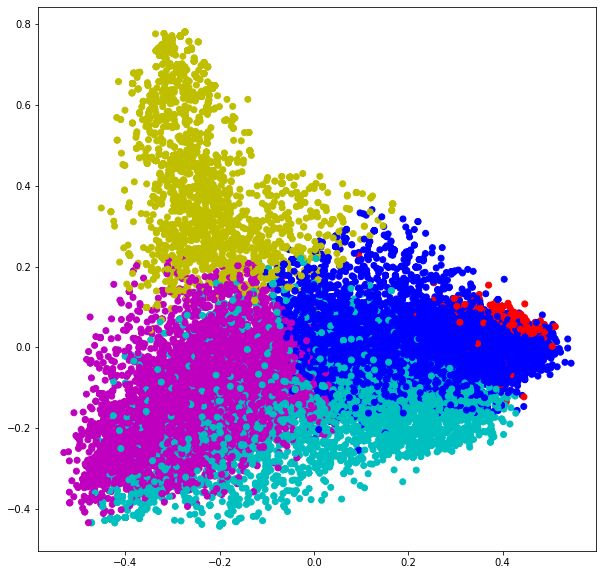

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])